Simple LSTM model based on Biderectional LSTM model

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'V52_data_process.csv'

# Display the first few rows to understand the structure of the data
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d%H%M%S')

# Set 'Date' column as index
df.set_index('Date', inplace=True)

# Interpolate missing values
df = df.interpolate()

# Check for NaN values after interpolation
nan_check = df.isna().sum().sum()
if nan_check > 0:
    raise ValueError(f"There are still NaN values in the dataset after interpolation: {nan_check}")

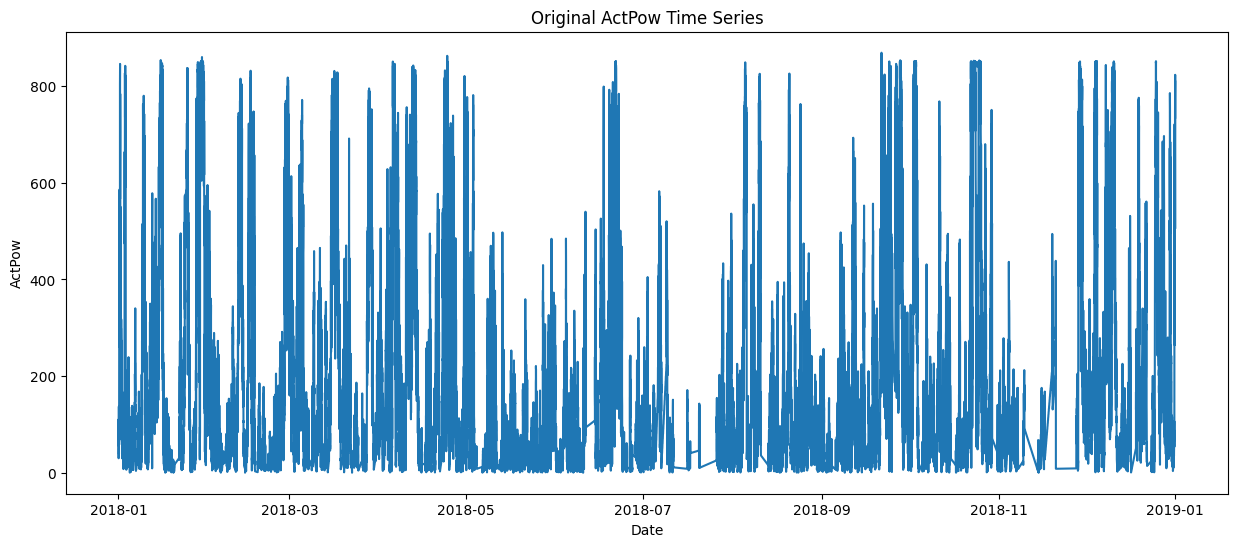

In [20]:
import matplotlib.pyplot as plt

# Visualize the time series data
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['ActPow'])
plt.title('Original ActPow Time Series')
plt.xlabel('Date')
plt.ylabel('ActPow')
plt.show()


X is th e input varaibels and y is the target variable  

**Always remeber LSTM can only work with one variable**

In [22]:
# Divide the time series into sequences
sequence_length = 10
sequences, target = [], []

for i in range(len(df) - sequence_length):
    seq = df.iloc[i:i+sequence_length]['ActPow'].values
    label = df.iloc[i+sequence_length]['ActPow']
    sequences.append(seq)
    target.append(label)

# Convert sequences and target to numpy arrays
X = np.array(sequences)
y = np.array(target)

# Reshape X to match LSTM input shape (samples, time steps, features)
X = X.reshape(X.shape[0], sequence_length)

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1))


In [23]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 10, 200)           81600     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 10, 200)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 100)               100400    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 182101 (711.33 KB)
Trainable params: 182101 (711.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


151 Mins at 100 epochs - Overfiting the model. No idea what happened but it just did not work (i got the saved model XD)\
72 misn for 50 epoch\
5 mins for 20 epoch\

batch_size 64 is default\

**total_iterations = (number_of_samples / batch_size) * epochs**\

In [24]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64 validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/20
986/986 [==============================] - 29s 24ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 2/20
986/986 [==============================] - 23s 23ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 3/20
986/986 [==============================] - 22s 22ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 4/20
986/986 [==============================] - 23s 23ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 5/20
986/986 [==============================] - 19s 20ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 6/20
986/986 [==============================] - 19s 20ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 7/20
986/986 [==============================] - 19s 20ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 8/20
986/986 [==============================] - 20s 20ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 9/20
986/986 [==============================] - 20s 20ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 10/20
986/986 [==============================] - 20s 20ms/step - loss: 0.002

In [25]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

329/329 [==============================] - 2s 6ms/step - loss: 0.0022
Test Loss: 0.0022141297813504934


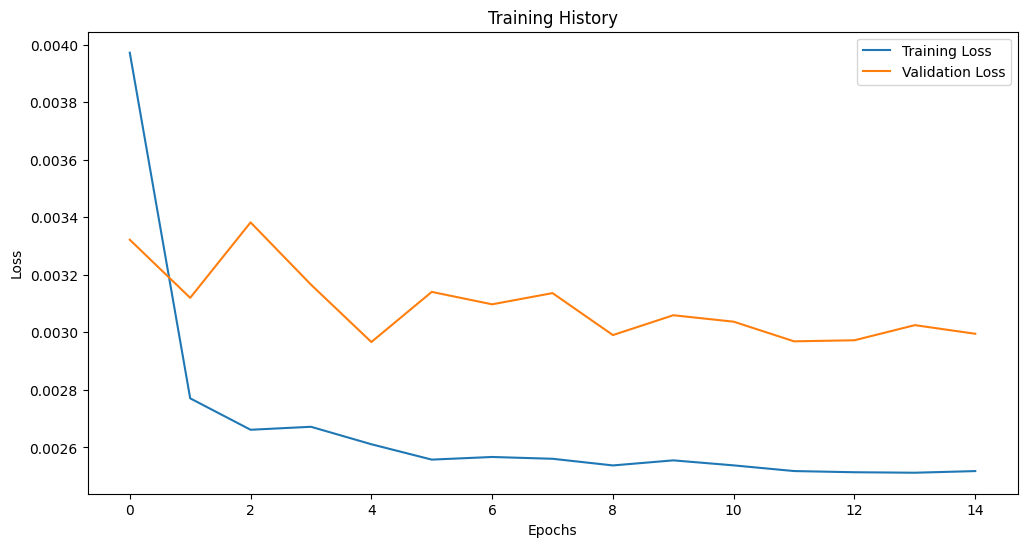

In [26]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


You can call the model later instead of doing the whole thing again. **lifesaver**

In [27]:
model.save('bidirectional_lstm_model.h5')

c:\Users\abhig\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fair enough

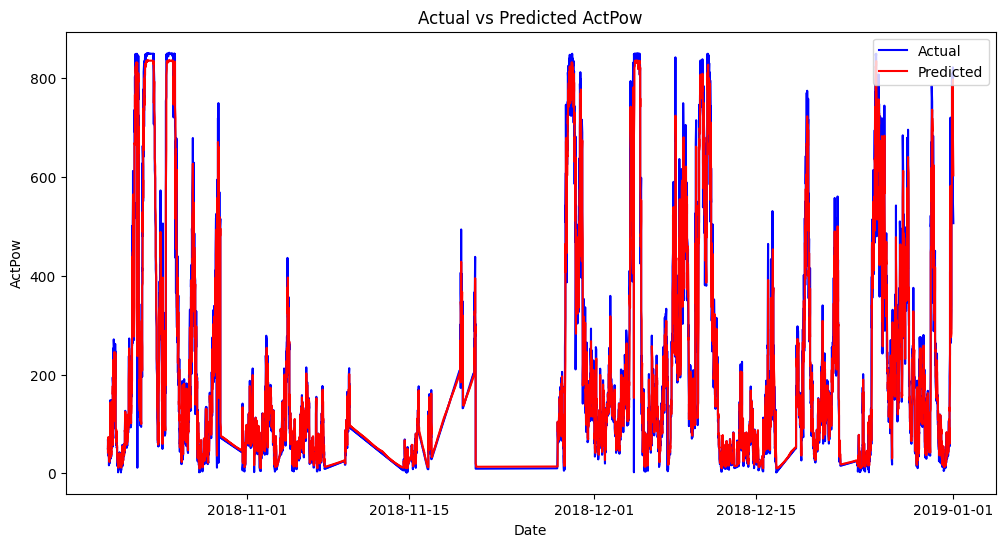

In [17]:
# Plot predictions vs actual values with connected lines and different colors
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual', linestyle='-', color='blue', alpha=1)
plt.plot(df.index[-len(future_predictions):], future_predictions, label='Predicted', linestyle='-', color='red', alpha=1)
plt.title('Actual vs Predicted ActPow')
plt.xlabel('Date')
plt.ylabel('ActPow')
plt.legend()
plt.show()
